In [180]:
#For fitting models
import statsmodels.formula.api as smf
import statsmodels.api as sm
#Used for some additional statistics
import scipy.stats as stats
import pandas as pd
import numpy as np
import math
#Used for descriping statistical models and data matrices
#Here, we just use the dmatrices function to create the design matrix for the model
from patsy import dmatrices
#For diagnostic plots
import matplotlib
import matplotlib.pyplot as plt

## Load and initial processing of data

In [181]:
#Load...
trip_data = pd.read_csv(r'..\data\interim\trips.csv', dtype = {'VORIHORAINI':str, 'VDESHORAFIN':str})

#Convert transport to categories
trip_data['mode'] = trip_data['MODO_PRIORITARIO']
trip_data.loc[trip_data.MODO_PRIORITARIO < 10, "mode"] = "public transport"
trip_data.loc[(trip_data.MODO_PRIORITARIO > 9) & (trip_data.MODO_PRIORITARIO < 17), "mode"] = "car"
trip_data.loc[(trip_data.MODO_PRIORITARIO > 16) & (trip_data.MODO_PRIORITARIO < 24), "mode"] = "other"
trip_data.loc[trip_data.MODO_PRIORITARIO == 24, "mode"] = "walk"

sex_dict  = {1: "male", 2: "female"}

trip_data = (trip_data
             #Remove records with 0 distance
             [trip_data.DISTANCIA_VIAJE != 0]
             #Drop rows where our focal cols are NA
             [['C2SEXO', 'mode', 'VORIHORAINI', 'VDESHORAFIN', 'DISTANCIA_VIAJE', 'ELE_G_POND_ESC2']]
             .dropna()
             #Rename to useful names
             .rename(columns = {"C2SEXO": "sex",
                                "VORIHORAINI" : "start_time", "VDESHORAFIN" : "end_time",
                                "DISTANCIA_VIAJE" : "distance", "ELE_G_POND_ESC2" : 'weight'})
             #Recode sex
             .replace({'sex': sex_dict})
             .reset_index())

In [182]:


#Pad times to all have nchar = 4
trip_data['start_time'] = trip_data['start_time'].apply(lambda x:'{:0>4}'.format(x))
trip_data['end_time'] = trip_data['end_time'].apply(lambda x:'{:0>4}'.format(x))

In [183]:
#Turn strings into decimal hours (e.g. 0030 = 0.5, 2515 = 25.25)
trip_data['start_time'] = trip_data['start_time'].apply(lambda x: int(x[:-2]) + int(x[2:])/60)
trip_data['end_time'] = trip_data['end_time'].apply(lambda x: int(x[:-2]) + int(x[2:])/60)
#Calculate duration in hrs
trip_data['duration'] = trip_data['end_time'] - trip_data['start_time']

#Remove cases with 0 duration
trip_data = trip_data[trip_data.duration != 0]

#Calculate speed (km/hr)
trip_data['speed'] = trip_data['distance']/trip_data['duration']

In [184]:
trip_data.head()

,index,sex,mode,start_time,end_time,distance,weight,duration,speed
0,0,male,car,8.000000,8.500000,6.660582,66.304668,0.500000,13.321164
1,1,male,car,18.000000,18.500000,6.660582,66.304668,0.500000,13.321164
2,3,male,car,8.000000,8.333333,6.586497,66.304668,0.333333,19.759491
3,4,male,car,18.000000,18.333333,6.586497,66.304668,0.333333,19.759491
4,5,female,walk,11.216667,11.250000,0.203441,69.473571,0.033333,6.103216


## Detailed data cleaning

### 1. Are all modes relevant?

In [185]:
(trip_data[['mode', 'index']]
 .groupby('mode')
 .count())

,index
mode,
car,89111
other,3450
public transport,54411
walk,70942


Number of trips under 'other' are very limited. Will be dropped.

In [186]:
trip_data = trip_data[trip_data['mode'] != 'other']

### 2. Do all modes have realistic speeds?

mode
car                 [[AxesSubplot(0.125,0.125;0.775x0.755)]]
public transport    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
walk                [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

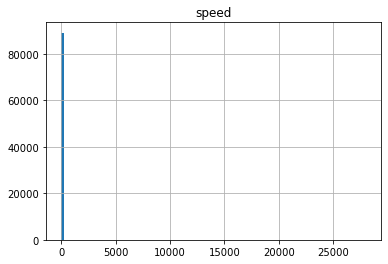

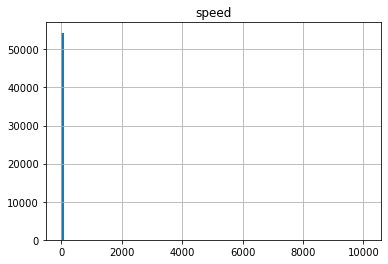

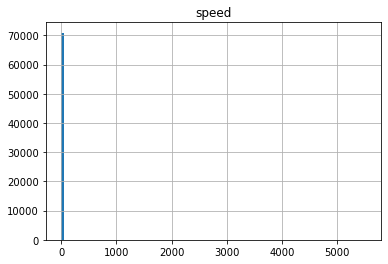

In [187]:
(trip_data[['mode', 'speed']]
.groupby('mode')
.hist(bins = 100))

There are some key outliers with speed way too high. We can filter these out using some decision rules:

- Max reasonable walking speed 9km/hr (according to wiki https://en.wikipedia.org/wiki/Preferred_walking_speed)
- Max reasonable PT speed of 100kph (motorway speed for bus: https://trans.info/en/new-speed-limits-are-in-force-in-spain-from-today-124104)
- Max reasonable car speed of 120kph (motorway speed for car: https://trans.info/en/new-speed-limits-are-in-force-in-spain-from-today-124104)

In [188]:
trip_data = trip_data[((trip_data['mode'] == 'car') & (trip_data['speed'] <= 120)) | ((trip_data['mode'] == 'public transport') & (trip_data['speed'] <= 100)) | ((trip_data['mode'] == 'walk') & (trip_data['speed'] <= 9))]

### 3. Do all modes have realistic distances?

mode
car                 [[AxesSubplot(0.125,0.125;0.775x0.755)]]
public transport    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
walk                [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

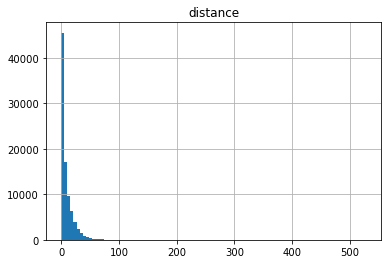

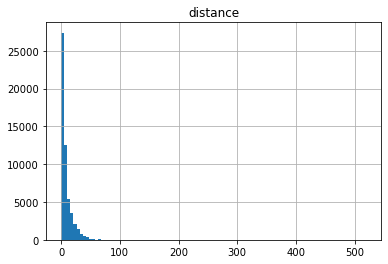

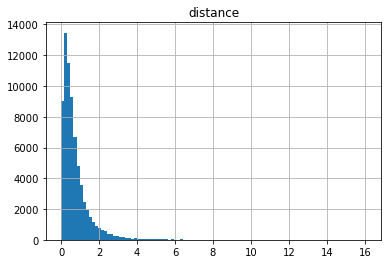

In [189]:
(trip_data[['mode', 'distance']]
.groupby('mode')
.hist(bins = 100))

Distances up to 500km seem unrealistic (or 16km for walking). We'll use 99th quantile to cut unrealistically large distances.

In [190]:
quantiles = (trip_data[['mode', 'distance']]
.groupby('mode')
.apply(lambda x: np.quantile(x, 0.99))
.reset_index())

quantiles.columns = ['mode', 'quantile']

quantiles.head()

,mode,quantile
0,car,54.510521
1,public transport,43.471175
2,walk,3.922442


In [191]:
trip_data = (trip_data
            .merge(quantiles, on = "mode", how = "left"))

trip_data = trip_data[((trip_data['mode'] == 'car') & (trip_data['distance'] <= trip_data['quantile'])) | ((trip_data['mode'] == 'public transport') & (trip_data['distance'] <= trip_data['quantile'])) | ((trip_data['mode'] == 'walk') & (trip_data['distance'] <= trip_data['quantile']))]

trip_data.head()

,index,sex,mode,start_time,end_time,distance,weight,duration,speed,quantile
0,0,male,car,8.000000,8.500000,6.660582,66.304668,0.500000,13.321164,54.510521
1,1,male,car,18.000000,18.500000,6.660582,66.304668,0.500000,13.321164,54.510521
2,3,male,car,8.000000,8.333333,6.586497,66.304668,0.333333,19.759491,54.510521
3,4,male,car,18.000000,18.333333,6.586497,66.304668,0.333333,19.759491,54.510521
4,5,female,walk,11.216667,11.250000,0.203441,69.473571,0.033333,6.103216,3.922442


In [192]:
len(trip_data)

212023

## Fit model

In [193]:
#Create a glm model object.
glm_gamma = smf.glm(formula = 'speed ~ C(mode, Treatment(reference="public transport")) * distance + C(mode, Treatment(reference="public transport")) * sex', data = trip_data,
                   #The family argument should take a family object from the `families` module
                   #If we want to use the non-default link we should provide an object of class link.
                   family=sm.families.Gamma(sm.families.links.log()),
                   freq_weights = trip_data['weight'])
glm_results = glm_gamma.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  speed   No. Observations:               212023
Model:                            GLM   Df Residuals:              15055524.30
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.27341
Method:                          IRLS   Log-Likelihood:            -4.1124e+07
Date:                Sun, 22 Nov 2020   Deviance:                   3.8542e+06
Time:                        19:42:45   Pearson chi2:                 4.12e+06
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

Test model fit

1. Plot residuals (homoskedasticity assumption is not required for Gamma)

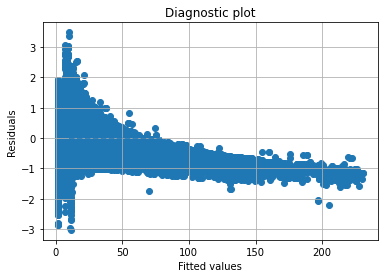

In [194]:
resid = glm_results.resid_deviance
fitted = glm_results.fittedvalues

#Create empty plot object
fig, ax = plt.subplots()
#Add x and y variables
ax.scatter(fitted, resid)
ax.hlines(y = 0, xmin = 10, xmax = 80, linestyles = 'dashed')
#Add labels
ax.set(xlabel='Fitted values', ylabel='Residuals',
       title='Diagnostic plot')
#Add plot grid
ax.grid()

plt.show()

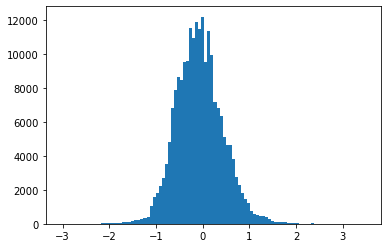

In [195]:
plt.hist(resid, bins = 100)

plt.show()

Some trend in residuals, do we need other terms in the model? Consider a non-linear relationship with distance.

In [196]:
glm_gamma_log = smf.glm(formula = 'speed ~ C(mode, Treatment(reference="public transport")) * np.log(distance) + C(mode, Treatment(reference="public transport")) * sex', data = trip_data2,
                   #The family argument should take a family object from the `families` module
                   #If we want to use the non-default link we should provide an object of class link.
                   family=sm.families.Gamma(sm.families.links.log()),
                   freq_weights = trip_data['weight'])
glm_results_log = glm_gamma_log.fit()
print(glm_results_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  speed   No. Observations:               212023
Model:                            GLM   Df Residuals:              15055524.30
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                         0.24184
Method:                          IRLS   Log-Likelihood:            -3.9805e+07
Date:                Sun, 22 Nov 2020   Deviance:                   3.2369e+06
Time:                        19:42:49   Pearson chi2:                 3.64e+06
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

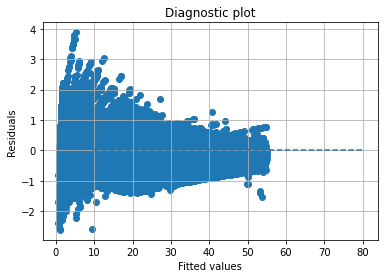

In [197]:
resid = glm_results_log.resid_deviance
fitted = glm_results_log.fittedvalues

#Create empty plot object
fig, ax = plt.subplots()
#Add x and y variables
ax.scatter(fitted, resid)
ax.hlines(y = 0, xmin = 10, xmax = 80, linestyles = 'dashed')
#Add labels
ax.set(xlabel='Fitted values', ylabel='Residuals',
       title='Diagnostic plot')
#Add plot grid
ax.grid()

plt.show()

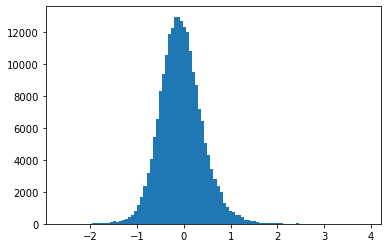

In [198]:
plt.hist(resid, bins = 100)

plt.show()

Looks much better. Look at parameter estimates and pvalues for sex at all modes (with multiple testing correction).

In [200]:
newalpha = 0.05/3

In [201]:
glm_gamma_logCAR = smf.glm(formula = 'speed ~ C(mode, Treatment(reference="car")) * np.log(distance) + C(mode, Treatment(reference="car")) * sex', data = trip_data2,
                   #The family argument should take a family object from the `families` module
                   #If we want to use the non-default link we should provide an object of class link.
                   family=sm.families.Gamma(sm.families.links.log()),
                   freq_weights = trip_data['weight'])
glm_results_logCAR = glm_gamma_logCAR.fit()

glm_gamma_logWALK = smf.glm(formula = 'speed ~ C(mode, Treatment(reference="walk")) * np.log(distance) + C(mode, Treatment(reference="walk")) * sex', data = trip_data2,
                   #The family argument should take a family object from the `families` module
                   #If we want to use the non-default link we should provide an object of class link.
                   family=sm.families.Gamma(sm.families.links.log()),
                   freq_weights = trip_data['weight'])
glm_results_logWALK = glm_gamma_logWALK.fit()

In [205]:
mod_estimates = pd.DataFrame({"mode": ['pt', 'car', 'walk'],
                              "est": [glm_results_log.params[3], glm_results_logCAR.params[3], glm_results_logWALK.params[3]],
                              "pval": [glm_results_log.pvalues[3], glm_results_logCAR.pvalues[3], glm_results_logWALK.pvalues[3]]})

mod_estimates['sig'] = mod_estimates['pval'] <= newalpha

mod_estimates

,mode,est,pval,sig
0,pt,0.027480,0.000000e+00,True
1,car,-0.008012,3.812835e-89,True
2,walk,-0.005990,1.125406e-41,True


All terms and significant even with conservative Bonferonni correction; however, effect size of PT is orders of magnitude greater than that for PT.

## Model predictions

We want to create a prediction of travel speed for each sex and mode of transport when distance is standardised.

In [127]:
meandist = (trip_data[['mode', 'distance']]
.groupby(['mode'])
.apply(lambda x: np.mean(x))
.reset_index())

meandist.head()

,mode,distance
0,car,8.617716
1,public transport,8.169416
2,walk,0.686894


In [128]:
modeldata = (pd.DataFrame({"mode": ["car", "car", "public transport", "public transport", "walk", "walk"],
                        "sex": ["male", "female", "male", "female", "male", "female"],
                        "intercept": [1, 1, 1, 1, 1, 1]})
           .merge(meandist, how = 'left', on = 'mode'))

modeldata['predspeed'] = glm_results_log.predict(modeldata)

modeldata

,mode,sex,intercept,distance,predspeed
0,car,male,1,8.617716,23.451326
1,car,female,1,8.617716,23.639969
2,public transport,male,1,8.169416,13.026626
3,public transport,female,1,8.169416,12.673531
4,walk,male,1,0.686894,2.811977
5,walk,female,1,0.686894,2.828873


In [99]:
modeldata.to_csv(r'..\data\processed\model_data.csv', index = False)